# Introduction

I am going to perform time series forecasting with XGBOOST.

### Data

Data contains over 10 years of hourly energy consumption data from PJM in Megawatts. 

PJM interconnection LLC is a regional trnasmission organization in the US and a part of the eastern interconnection grid operating an electric transmission system. 

### Goal

1. build a model to predict energy consumption?

2. finding trends in energy consumption around hours of the day, holidays, or long term trends?

3. understanding how daily trends change depending of the time of year?

### 1. Loading libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import pandas_profiling as pp
import pandas.util.testing as tm

C:\Users\C978167\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 2. Reading Data

In [24]:
df_comEd = pd.read_csv('Data/COMED_hourly.csv', index_col=[0], parse_dates=[0])
df_pjme = pd.read_csv('Data/PJM_hourly_est.csv', index_col=[0], parse_dates=[0])

In [4]:
# examining the data using pandas_profiling
pp.ProfileReport(df_comEd)

In [ ]:
# pp.ProfileReport(pjme_hourly)

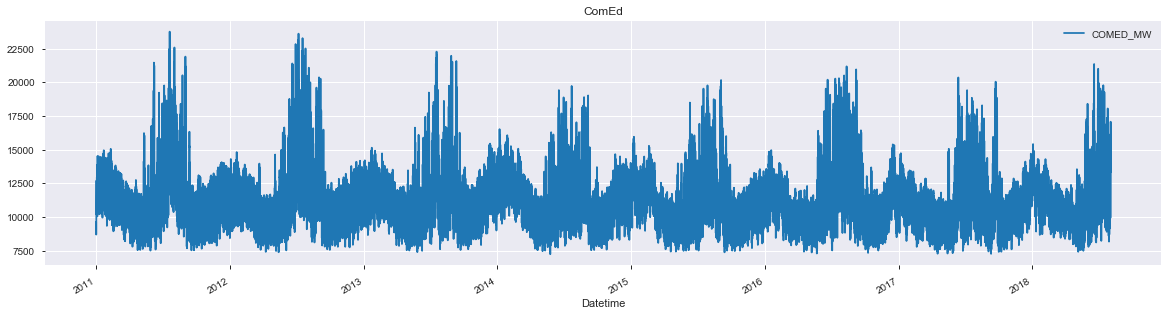

In [6]:
# visualizating using plot
plot_comEd = df_comEd.plot(style='', figsize=(20,5), title='ComEd')

In [30]:
# creating time series features from date_time to see trends hourly/monthly
def create_features(df_comEd):
    df = df_comEd.copy()
    
    df['date'] = df.index
    
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    y = df['COMED_MW']
    
    df_features_target = pd.concat([X, y], axis=1)
    
    return df_features_target

df_features_target = create_features(df_comEd)

#df_features_target.head()
pp.ProfileReport(df_features_target)

In [31]:
df_features_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,COMED_MW
Datetime,,,,,,,,,
2011-12-31 01:00:00,1,5,4,12,2011,365,31,52,9970.0
2011-12-31 02:00:00,2,5,4,12,2011,365,31,52,9428.0
2011-12-31 03:00:00,3,5,4,12,2011,365,31,52,9059.0
2011-12-31 04:00:00,4,5,4,12,2011,365,31,52,8817.0
2011-12-31 05:00:00,5,5,4,12,2011,365,31,52,8743.0


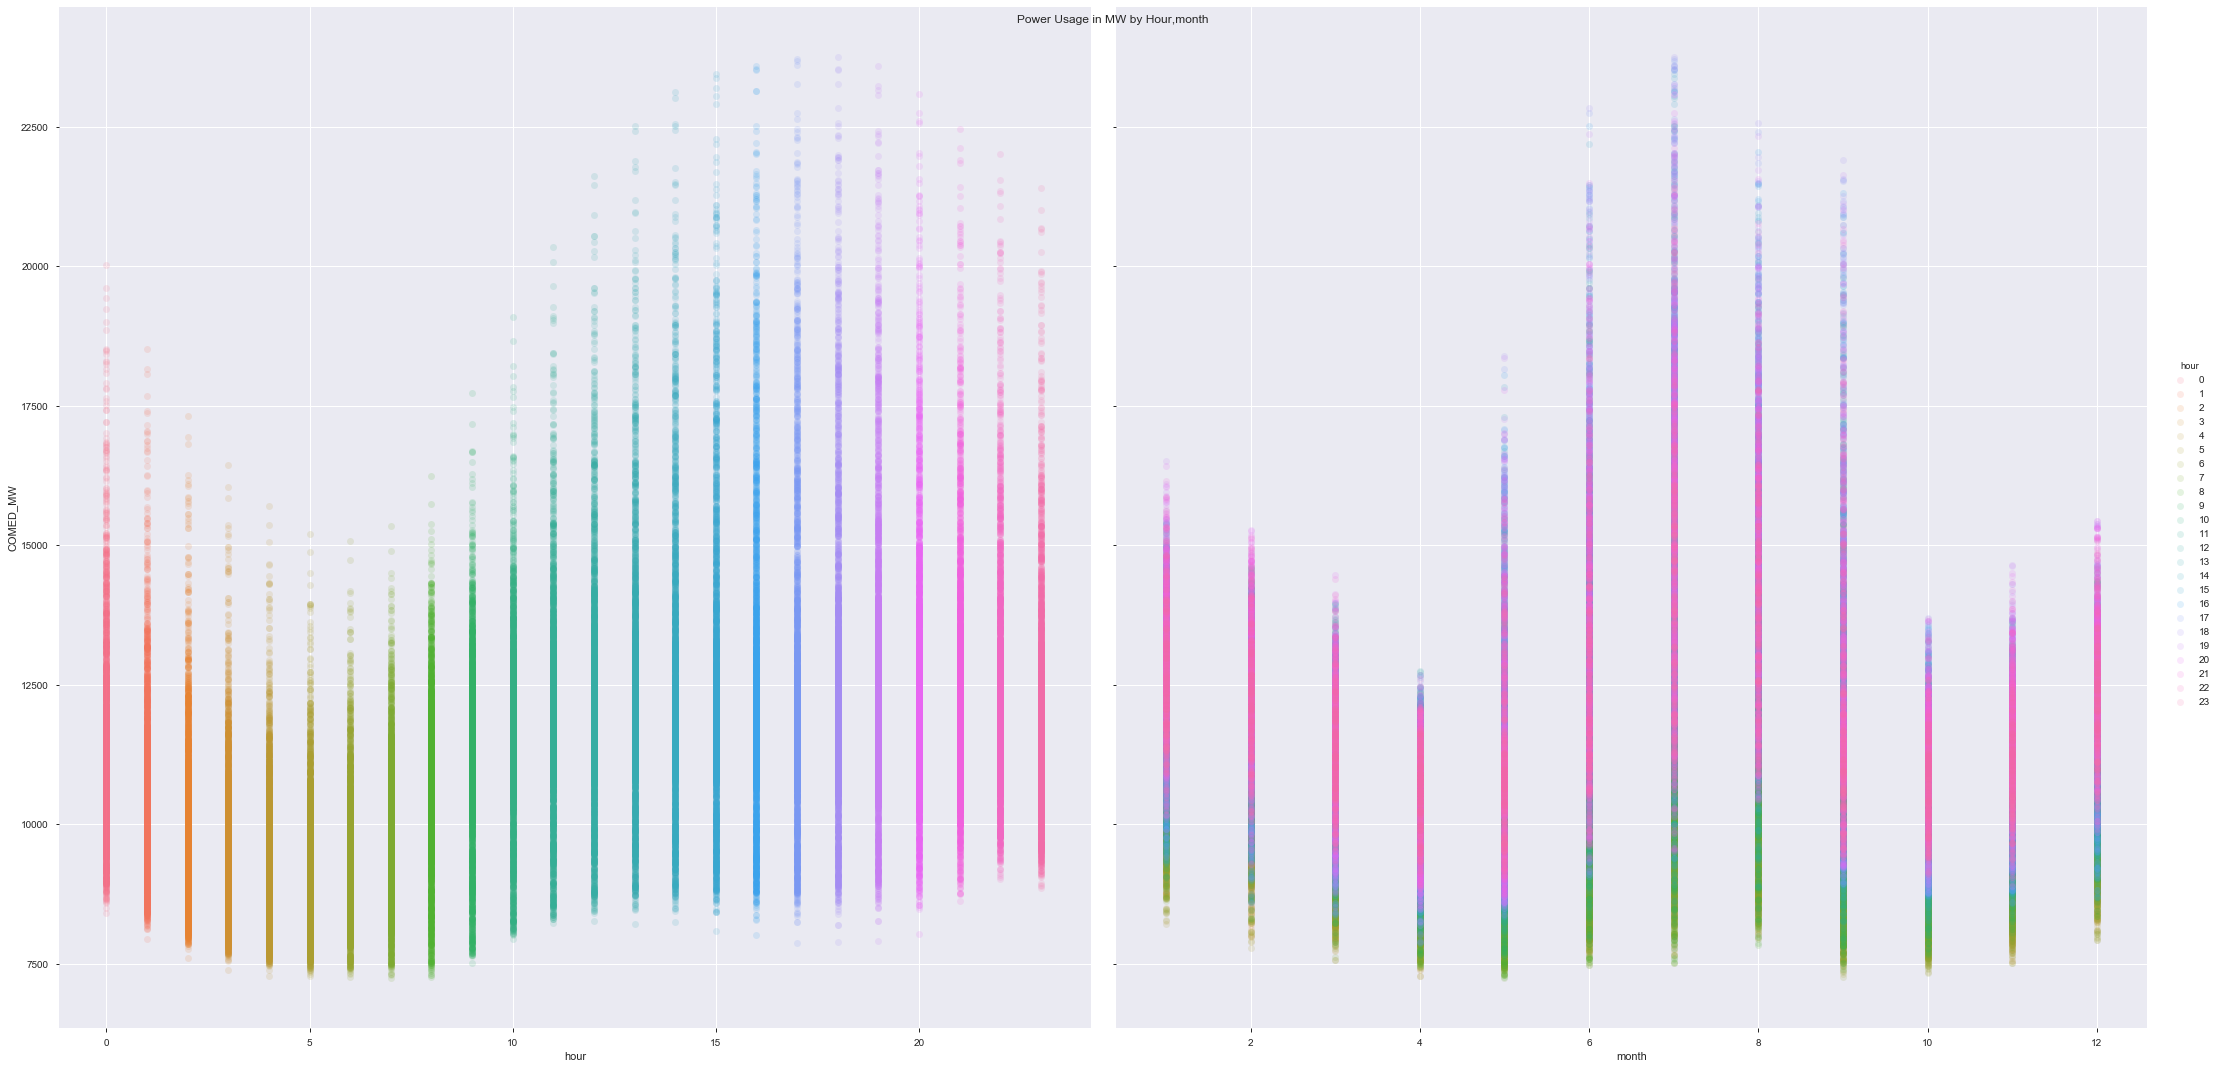

In [41]:
# plot the features to see the trend
import matplotlib.pyplot as plt 
sns.pairplot(df_features_target.dropna(),
             hue='hour',
             x_vars=['hour','month'],
             y_vars='COMED_MW',
             height=15,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Usage in MW by Hour,month')
plt.show()

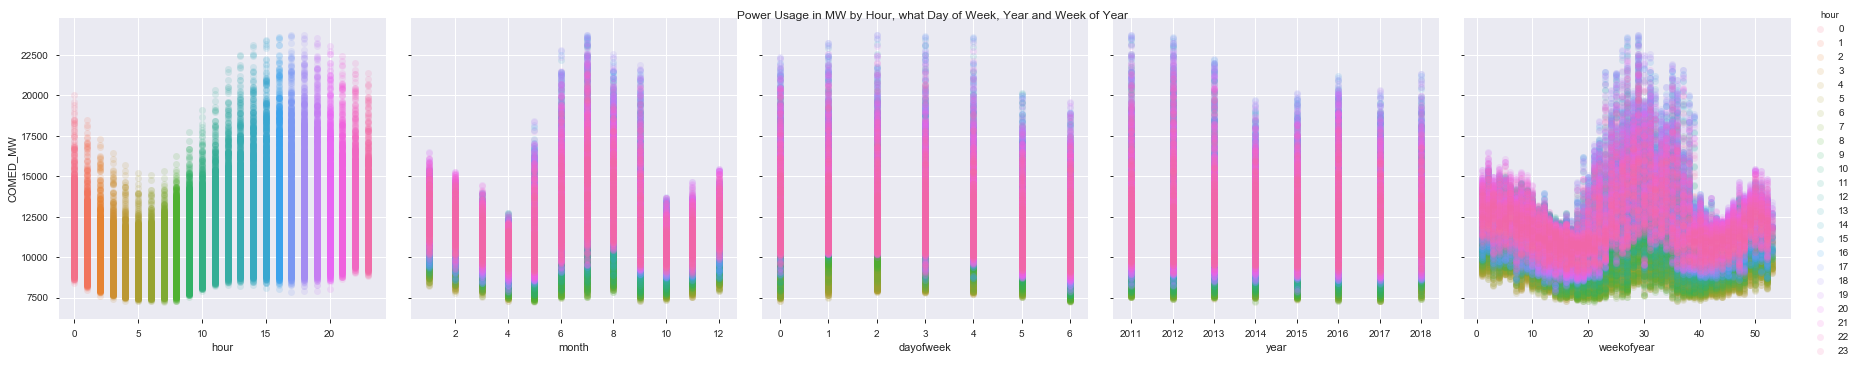

In [42]:
# plot the features to see the trend
import matplotlib.pyplot as plt 
sns.pairplot(df_features_target.dropna(),
             hue='hour',
             x_vars=['hour','month','dayofweek',
                     'year','weekofyear'],
             y_vars='COMED_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Usage in MW by Hour, what Day of Week, Year and Week of Year')
plt.show()